In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_absolute_percentage_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
wines = pd.read_csv("winequalityN.csv")

In [3]:
wines["type"] = (wines["type"] == "red").astype(float)
wines.sample(3)

,type,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
3656,0.0,7.1,0.28,0.28,8.5,0.030,25.0,191.0,0.99338,3.16,0.46,12.2,7
5862,1.0,8.5,0.47,0.27,1.9,0.058,18.0,38.0,0.99518,3.16,0.85,11.1,6
2682,0.0,7.6,0.32,0.25,9.5,0.030,15.0,136.0,0.99367,3.10,0.44,12.1,6


## Оцениваем target

Значения quality лежат в диапазоне от 3 до 9, в основном - 5, 6, 7 (93% значений), нулевых нет. Для оценки регрессии можно использовать все основные метрики: MAE, MSE, R2, MAPE (среднюю абсолютную процентную ошибку).

In [4]:
print(wines["quality"].value_counts())

6    2836
5    2138
7    1079
4     216
8     193
3      30
9       5
Name: quality, dtype: int64


Quality '5', '6', '7' percentage: 93.17%


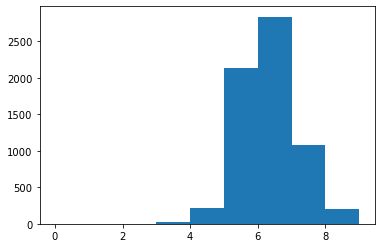

In [5]:
plt.hist(wines["quality"], bins=range(0, 10));
print("Quality '5', '6', '7' percentage: {:.2%}".format(
    wines[wines["quality"].isin([5,6,7])].shape[0] / wines.shape[0]))

## Оцениваем features

In [6]:
for clmn in wines.columns:
    print("{:22} {:10} {:2}".format(clmn, str(wines[clmn].dtype), wines[clmn].isna().sum()))

type                   float64     0
fixed acidity          float64    10
volatile acidity       float64     8
citric acid            float64     3
residual sugar         float64     2
chlorides              float64     2
free sulfur dioxide    float64     0
total sulfur dioxide   float64     0
density                float64     0
pH                     float64     9
sulphates              float64     4
alcohol                float64     0
quality                int64       0


## Избавляемся от NaN
Неопределено всего 38 значений в 34 записях (~0,5% от базы). Запись '0' или среднего показало ухудшение предсказательной способности модели. В данном случае их проще (и лучше) дропнуть.

In [7]:
# wines["fixed acidity"] = wines["fixed acidity"].fillna(wines["fixed acidity"].mean())
wines = wines.dropna(subset=[
    "fixed acidity", "volatile acidity", "citric acid", "residual sugar", "chlorides", "pH", "sulphates"
], axis=0)
wines.shape

(6463, 13)

## Разбиваем еще на два датасета (для белого и красного)

In [8]:
white_wines = wines[wines["type"] == 0]
red_wines = wines[wines["type"] == 1]

white_wines.drop(columns=["type"])
red_wines.drop(columns=["type"])

white_wines.shape, red_wines.shape

((4870, 13), (1593, 13))

## Строим регрессии для полного датасета

In [9]:
def experiment(wines, lr):
    y = wines["quality"]
    X = wines.drop("quality", axis=1)
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)
    
    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    lr.fit(X_train, y_train)
    y_pred = lr.predict(X_test)
    
    return lr, y_test, y_pred

In [10]:
def print_metrics(lr, y_test, y_pred):
    print("Coefficients: \n", lr.coef_)
    print("Mean squared error: %.5f" % mean_squared_error(y_test, y_pred))
    print("Mean absolute error: %.5f" % mean_absolute_error(y_test, y_pred))
    # 1 is perfect prediction
    print("Coefficient of determination: %.5f" % r2_score(y_test, y_pred))
    print("Mean absolute percentage error: %.5f" % mean_absolute_percentage_error(y_test, y_pred))

In [11]:
lr, y_test, y_pred = experiment(wines, LinearRegression())
print_metrics(lr, y_test, y_pred)

Coefficients: 
 [ 0.1760856   0.09299824 -0.24503851 -0.0048339   0.29719194 -0.03625076
  0.08229644 -0.06169023 -0.29458393  0.0769122   0.10482348  0.26088812]
Mean squared error: 0.50639
Mean absolute error: 0.55943
Coefficient of determination: 0.33875
Mean absolute percentage error: 0.09929


In [12]:
print_metrics(*experiment(wines, Lasso(alpha=0.0001)))

Coefficients: 
 [ 0.17471266  0.09129561 -0.24489933 -0.00466895  0.29439554 -0.03623969
  0.08218411 -0.06167159 -0.29049789  0.07591219  0.10446195  0.26249146]
Mean squared error: 0.50642
Mean absolute error: 0.55946
Coefficient of determination: 0.33871
Mean absolute percentage error: 0.09930


## Строим регрессии для "белого" и "красного" датасетов

In [13]:
lr, y_test_white, y_pred_white = experiment(white_wines, LinearRegression())
print_metrics(lr, y_test_white, y_pred_white)

Coefficients: 
 [ 0.          0.03945724 -0.19273679  0.01103734  0.41282431 -0.01207327
  0.0549712  -0.00582673 -0.42346897  0.09365149  0.0736016   0.2417739 ]
Mean squared error: 0.53043
Mean absolute error: 0.57694
Coefficient of determination: 0.30885
Mean absolute percentage error: 0.09981


In [14]:
print_metrics(*experiment(white_wines, Lasso(alpha=0.0001)))

Coefficients: 
 [ 0.          0.03842458 -0.1927798   0.01090185  0.41016806 -0.01217529
  0.05486589 -0.00569326 -0.41968153  0.09277861  0.07330058  0.24338123]
Mean squared error: 0.53046
Mean absolute error: 0.57696
Coefficient of determination: 0.30881
Mean absolute percentage error: 0.09981


In [15]:
lr, y_test_red, y_pred_red = experiment(red_wines, LinearRegression())
print_metrics(lr, y_test_red, y_pred_red)

Coefficients: 
 [ 0.          0.0244142  -0.18605626 -0.0374086   0.02507884 -0.06879497
  0.0459863  -0.10687792 -0.00368583 -0.06728721  0.12556166  0.33243495]
Mean squared error: 0.44333
Mean absolute error: 0.52067
Coefficient of determination: 0.34211
Mean absolute percentage error: 0.09702


In [16]:
print_metrics(*experiment(red_wines, Lasso(alpha=0.0001)))

Coefficients: 
 [ 0.          0.02361006 -0.18592091 -0.03692096  0.02472257 -0.06871937
  0.04579868 -0.10669704 -0.00300344 -0.0673676   0.12532409  0.33270762]
Mean squared error: 0.44338
Mean absolute error: 0.52072
Coefficient of determination: 0.34204
Mean absolute percentage error: 0.09703


## Проводим 10 экспериментов со случайными разбиениями

In [17]:
def multi_experiment(wines, lr):
    mse, mae, r2, mape = [], [], [], []

    ss = ShuffleSplit(n_splits=10, train_size=0.7, random_state=42)
    y = wines["quality"]
    X = wines.drop("quality", axis=1)
    for train_index, test_index in ss.split(y):
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)
    
        lr.fit(X_train, y_train)
        y_pred = lr.predict(X_test)
        
        mse.append(mean_squared_error(y_test, y_pred))
        mae.append(mean_absolute_error(y_test, y_pred))
        r2.append(r2_score(y_test, y_pred))
        mape.append(mean_absolute_percentage_error(y_test, y_pred))
    
    print("Mean squared error: %.5f" % np.mean(mse))
    print("Mean absolute error: %.5f" % np.mean(mae))
    print("Coefficient of determination: %.5f" % np.mean(r2))
    print("Mean absolute percentage error: %.5f" % np.mean(mape))

In [18]:
multi_experiment(wines, LinearRegression())

Mean squared error: 0.53214
Mean absolute error: 0.56673
Coefficient of determination: 0.30140
Mean absolute percentage error: 0.10106


In [19]:
multi_experiment(wines, Lasso(alpha=0.0001))

Mean squared error: 0.53212
Mean absolute error: 0.56674
Coefficient of determination: 0.30143
Mean absolute percentage error: 0.10106


In [20]:
multi_experiment(white_wines, LinearRegression())

Mean squared error: 0.55823
Mean absolute error: 0.58383
Coefficient of determination: 0.28488
Mean absolute percentage error: 0.10268


In [21]:
multi_experiment(white_wines, Lasso(alpha=0.0001))

Mean squared error: 0.55818
Mean absolute error: 0.58384
Coefficient of determination: 0.28494
Mean absolute percentage error: 0.10268


In [22]:
multi_experiment(red_wines, LinearRegression())

Mean squared error: 0.42530
Mean absolute error: 0.51109
Coefficient of determination: 0.35980
Mean absolute percentage error: 0.09374


In [23]:
multi_experiment(red_wines, Lasso(alpha=0.0001))

Mean squared error: 0.42531
Mean absolute error: 0.51112
Coefficient of determination: 0.35979
Mean absolute percentage error: 0.09374


## Вывод

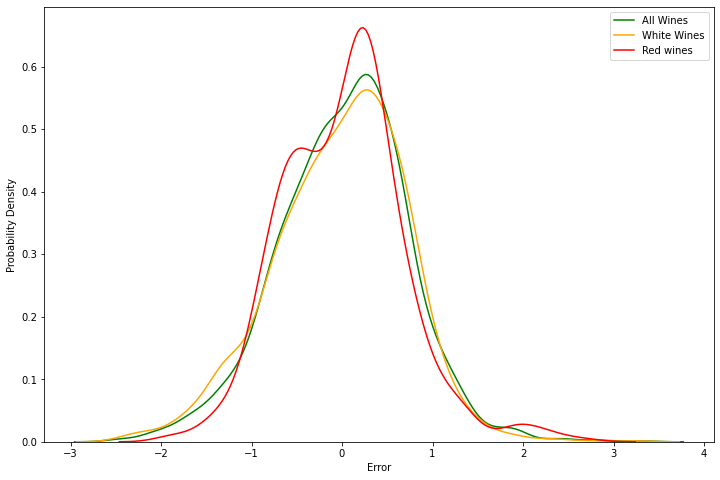

In [24]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

plt.rcParams['figure.figsize']=(12, 8) 
y_delta = y_pred - y_test
y_delta_white = y_pred_white - y_test_white
y_delta_red = y_pred_red - y_test_red
sns.kdeplot(y_delta, color='green', label='All Wines')
sns.kdeplot(y_delta_white, color='orange', label='White Wines')
sns.kdeplot(y_delta_red, color='red', label='Red wines')
plt.xlabel('Error') 
plt.ylabel('Probability Density')
plt.legend()
plt.show()

Абсолютная средняя ошибка построенной регрессии составляет 0,566 балла.

Кроме того, среднеквадратичная ошибка невысокая (0,532) - это свидетельствует о том, что нет частых **больших** отклонений предсказаные значений от истинных.